## Importing Modules

In [2]:
#Importing Necessary Modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split

## Data Preprocessing 

In [16]:
attrition_df = pd.read_csv('HR-Employee-Attrition.csv')
attrition_df = pd.get_dummies(attrition_df) #Convert categorical columns to discrete numbers
attrition_df = attrition_df.drop(['Attrition_No','Gender_Female','OverTime_No','EmployeeCount',
                                  'StandardHours','Over18_Y',
                                  'EmployeeNumber'],axis=1) #Dropping useless columns (Same value, ID, Extra Category)

attrition_df = attrition_df.rename(columns={"Attrition_Yes": "Attrition", "OverTime_Yes": "OverTime"}) 
#Because converted categorical columns change names, change binary categories back to their original names

y= attrition_df['Attrition']
X=attrition_df.drop('Attrition',axis=1) #Separate data into X and Y columns

non_numeric_cols = ['JobLevel','StockOptionLevel','BusinessTravel_Non-Travel','BusinessTravel_Travel_Frequently',
                    'BusinessTravel_Travel_Rarely','Department_Human Resources','Department_Research & Development',
                    'Department_Sales','EducationField_Human Resources','EducationField_Life Sciences',
                    'EducationField_Marketing','EducationField_Medical','EducationField_Other',
                    'EducationField_Technical Degree','Gender_Male','JobRole_Healthcare Representative',
                    'JobRole_Manufacturing Director','JobRole_Human Resources','JobRole_Laboratory Technician',
                    'JobRole_Manager','JobRole_Research Director','JobRole_Research Scientist','JobRole_Sales Executive',
                    'JobRole_Sales Representative','MaritalStatus_Divorced','MaritalStatus_Married','MaritalStatus_Single',
                    'OverTime','Education','EnvironmentSatisfaction','JobInvolvement','JobSatisfaction','PerformanceRating',
                    'RelationshipSatisfaction','WorkLifeBalance'] #Categorical Columns

numeric_df = attrition_df.drop(non_numeric_cols, axis=1) #Dataframe with only numerical columns, including Y-column 'Attrition'

print(numeric_df.columns)



Index(['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'Attrition'],
      dtype='object')


## Experimenting with Correlation

In [ ]:
#corr_mask = np.triu(np.ones_like(attrition_df.corr(), dtype=bool))
tri_df = attrition_df.corr().abs().mask(corr_mask)
plt.figure(figsize=(20,20))
#sns.heatmap(attrition_df.corr().abs(),mask=corr_mask,annot=True,fmt='.0%')
to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.7)]
print('to_drop columns: ', to_drop)
df_exp = attrition_df.drop(to_drop, axis=1)
df_exp.corr()
sns.heatmap(df_exp.corr().abs(),annot=True,fmt='.0%')

X= df_exp.drop('Attrition',axis=1)
y=df_exp['Attrition']

## Random Forest Construction and Model Evaluation 

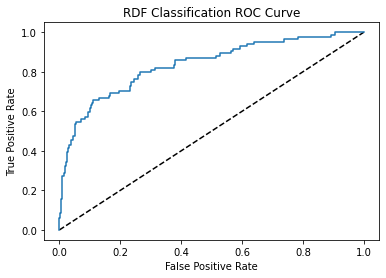

auc_score:  0.8347338935574229


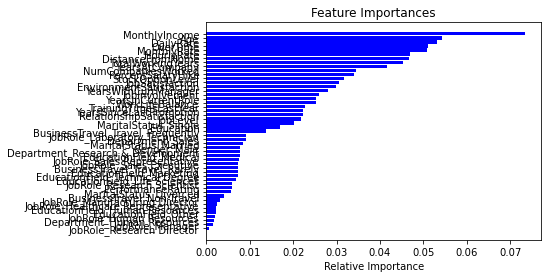

[[354   3]
 [ 71  13]]
accuracy:  0.8321995464852607
recall:  0.8329411764705882
FPR:  0.1875
cv_accuracy_score:  0.8600513992004568


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
RDF = RandomForestClassifier(random_state=123, max_depth=10, n_estimators=500)
RDF.fit(X_train, y_train)
y_pred = RDF.predict(X_test)
y_prob = RDF.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Random Forest Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RDF Classification ROC Curve')
plt.show()
print('auc_score: ', roc_auc_score(y_test, y_prob))

features = X.columns
importances = RDF.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
print('accuracy: ', (cf_matrix[0,0]+cf_matrix[1,1])/np.sum(cf_matrix))
print('recall: ', cf_matrix[0,0]/(cf_matrix[0,0]+cf_matrix[1,0]))
print('FPR: ', cf_matrix[0,1]/(cf_matrix[0,1]+cf_matrix[1,1]))

k_fold = KFold(n_splits=10, shuffle=True, random_state=123)
score = cross_val_score(RDF, X_train, y_train, cv=k_fold, scoring='accuracy')
print('cv_accuracy_score: ',score.mean())

## Hyperparameter Tuning using GridSearchCV

In [18]:
#Hyper-parameter Tuning

#random_grid = {'n_estimators': [100, 200, 300, 500],
               #'max_depth': [5, 10, 20, 30]}

#grid_search = GridSearchCV(estimator = RDF, param_grid = random_grid, 
                          #cv = k_fold, verbose = 1)

#grid_search.fit(X_train, y_train)
#print(print(grid_search.best_params_))

## Using reduced columns based on feature importance to construct a new RDFR Model

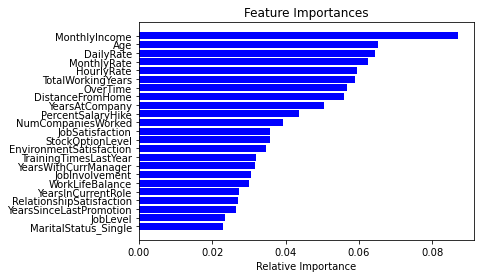

[[353   4]
 [ 73  11]]
accuracy:  0.8253968253968254
recall:  0.8286384976525821
FPR:  0.26666666666666666
cv_accuracy_score:  0.8619836284028175


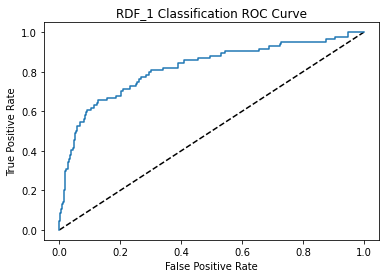

auc score: 0.8189942643724157


In [19]:
fi_mask = RDF.feature_importances_ > 0.02
X_reduced = X.loc[:, fi_mask]

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=10)
RDF1 = RandomForestClassifier(random_state=123,max_depth=10, n_estimators=500)
RDF1.fit(X_train, y_train)
y_pred = RDF1.predict(X_test)
y_prob = RDF1.predict_proba(X_test)[:,-1]


features = X_reduced.columns
importances = RDF1.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
print('accuracy: ', (cf_matrix[0,0]+cf_matrix[1,1])/np.sum(cf_matrix))
print('recall: ', cf_matrix[0,0]/(cf_matrix[0,0]+cf_matrix[1,0]))
print('FPR: ', cf_matrix[0,1]/(cf_matrix[0,1]+cf_matrix[1,1]))

k_fold = KFold(n_splits=10, shuffle=True, random_state=123)
score = cross_val_score(RDF1, X_train, y_train, cv=k_fold, scoring='accuracy')
print('cv_accuracy_score: ',score.mean())

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Random Forest Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RDF_1 Classification ROC Curve')
plt.show()

print('auc score:',roc_auc_score(y_test, y_prob))

